# Proyecto 04 - Sistemas de Recomendación

Proyecto con fin académico realizado por Carlos Rodriguez, contacto carlosd2.rodriguez@gmail.com https://github.com/carlosrosan/ACAMICA


## data_reviews: STEAM

**Origen de los datos de juegos y reviews [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

#### Objetivo: Mejorar un modelo de machine learning de Filtro Colaborativo para un sistema de recomendación de juegos, con métodos de NPL y fuentes de data complementarias mediante web scrapping.

In [1]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 20
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

data_reviews = pd.DataFrame(data_reviews)
data_reviews.head(3)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,found_funny,compensation
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
2,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [2]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

## Acerca de la predicción de la entrega anterior: Target metascore.

Hay limitaciones de Memoria RAM para el procesamiento del data_reviews. Con 16 GB RAM no fue posible para mi procesar el 100% del data_reviews de reviews, solo logré procesar el 70%.

Predecir recomendaciones mediante rating sirve para casos muy particulares y no es funcional todo el tiempo. Por ejemplo, si abro por primera vez una web de Ecommerce espero ver los productos mejor calificados, pero luego de filtrar de forma manual o buscar de forma repetitiva en la misma web, espero ver que las recomendaciones cada vez más se ajusten a mis parámetros de búsqueda.

Por lo cual, si bien tenía una expectativa de generar recomendaciones con data_reviewss de comportamiento de búsqueda, en realidad solo podemos hacer recomendaciones basadas en los productos de mejor rating.

Finalmente, creo que quizá sea necesario balancear el hecho que algunos usuarios aportan más datos que otros (califican más juegos, generan mas horas y metascore) mediante la sustracción del metascore medio del usuario de todas las calificaciones del mismo

## Propuestas a probar en esta entrega:

1 ) Usar el feature found funny y el texto de dejó el usuario al calificar, para mejorar el sistema de recomendación, usado librerías de procesamiento de lenguaje natural. Evitar el metascore y generar una métrica numérica de rating de cada review a partir del texto de la calificación. Depender del metascore es depender de una variable calculada por la plataforma y no generada por el usuario (no depende del data_reviews de revies ya que es un feature del juego). 

2 ) Considerar de igual manera en la ponderación la variable "found funny" ya que ella define si la calificación fue negativa o positiva. Solo usar el data_reviews de juegos para extraer el título y género.

3 ) data_reviews externo: web actual de Steam https://store.steampowered.com/ obtener nuevas reseñas para testear la predicción, inclusive usando mi cuenta personal de Steam para entender si las recomendaciones se alinean. Usar web scrapping con Selenium y Beautifullsoup.

# Resultados esperados:

Un script de python que genere recomendaciones basado en data más flexible en su origen (scrapping) y más relacionado a la review de cada usuario (texto de la review de cada uno). Esto no implica mejorar el performance del modelo como objetivo, pero si mejorar la adaptabilidad del mismo.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd

C:\Users\Eric\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Análisis exploratorio de datos general

In [4]:
# Los 10 más populares
for i in range(0,9):
    print(data_games[data_games.id==str(data_reviews.product_id.value_counts().index[i])].title.values)

['Team Fortress 2']
['Rust']
['Borderlands 2']
['Fallout 4']
['Grand Theft Auto V']
['Undertale']
['DayZ']
['Portal 2']
['Robocraft']


In [5]:
# Los 10 menos populares
for i in range(0,9):
    print(data_games[data_games.id==str(data_reviews.product_id.value_counts(ascending=True).index[i])].title.values)

['OVO Smash!']
['Airship Asunder']
['Legends of Pixelia']
['Prehistoric Tales']
['Factory Engineer']
['BusinessMan']
['Rescue From Goblin Deep']
['Diamond Joyce and the Secret of Crystal Cave']
['Umineko When They Cry - Answer Arcs']


#### Aplicaremos las transformaciones sobre el data_reviews, las mismas que realizamos sobre el trabajo anterior

In [6]:
print(data_reviews.shape)
data_reviews.product_id = data_reviews.product_id.replace(['NA'],np.nan)
data_reviews = data_reviews[~data_reviews.product_id.isna()]
data_reviews = data_reviews[~data_reviews.user_id.isna()]
print(data_reviews.shape)

(389654, 12)
(158494, 12)


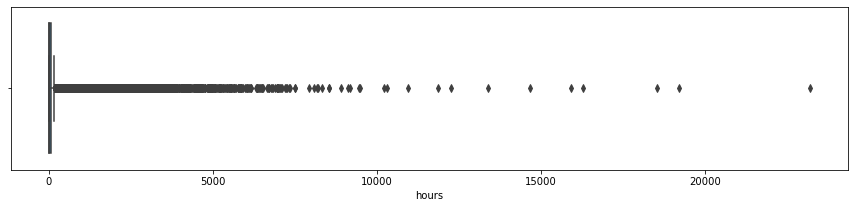

In [7]:
#Gráfico de horas jugadas por usuario por juego

plt.subplots(figsize=(15,3))
sns.boxplot(x=data_reviews[~data_reviews['hours'].isna()]['hours'])

count    158086.000000
mean        121.489181
std         391.957199
min           0.000000
25%           4.800000
50%          18.600000
75%          73.000000
max       23184.200000
Name: hours, dtype: float64
121.48918120516532 391.9571992914622 -1054.3824166692214 1297.360779079552
count    155385.000000
mean         82.429330
std         173.880721
min           0.000000
25%           4.700000
50%          17.900000
75%          67.000000
max        1297.000000
Name: hours, dtype: float64


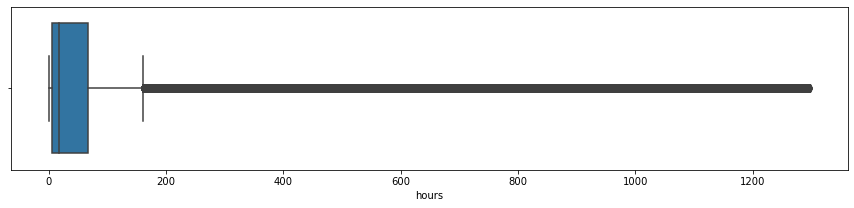

In [8]:
# Existen juegos y usuarios con cantidades de horas jugadas que pueden considerarse como outliers, las cuales eliminaremos.

print(data_reviews['hours'].describe())

valor_medio = data_reviews['hours'].mean()
std = data_reviews['hours'].std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers = np.logical_or(data_reviews['hours'] < minimo, data_reviews['hours'] > maximo)
print(valor_medio, std, minimo, maximo)

data_reviews = data_reviews[~mascara_outliers]
print(data_reviews['hours'].describe())

plt.subplots(figsize=(15,3))
sns.boxplot(x=data_reviews[~data_reviews['hours'].isna()]['hours'])

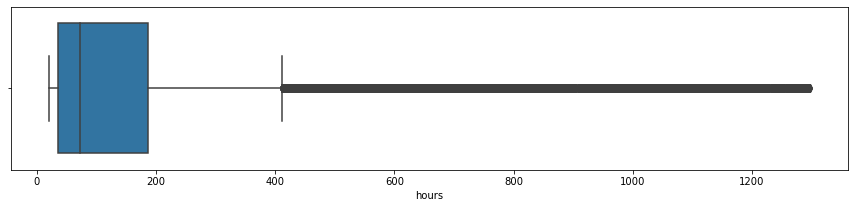

In [9]:
# Filtraremos los juegos jugados por más de 2 usuarios y por mas de 20 horas por usuario

data_reviews = data_reviews[data_reviews['hours'] >= 20]
plt.subplots(figsize=(15,3))
sns.boxplot(x=data_reviews[~data_reviews['hours'].isna()]['hours'])

In [10]:
# Eliminaremos los juegos con pocos reviews (menos de 2)

print(data_reviews.shape)
data_reviews = data_reviews.groupby('user_id').filter(lambda x: len(x) >= 2)
data_reviews.user_id.value_counts()
print(data_reviews.shape)

(74060, 12)
(6599, 12)


In [11]:
data_games = data_games.rename(columns={'id':'product_id'})
data_reviews = data_reviews.merge(data_games, on='product_id', how='left')

# Transformaremos los tipos de datos
data_reviews.metascore = data_reviews.metascore.replace(['NA'],np.nan)
data_reviews.metascore = data_reviews.metascore.astype(np.float32)
data_reviews.product_id = data_reviews.product_id.astype(int) 

# Eliminaremos los valores faltatentes, excepto found funny que parece tener un significado (sustituiremos por 0)

print(data_reviews.shape)
data_reviews = data_reviews[~data_reviews.text.isna()]

data_reviews.found_funny = data_reviews.found_funny.fillna(0)

data_games = data_games[~data_games.product_id.isna()]
data_games.product_id = data_games.product_id.astype(int)
print(data_reviews.shape)

data_reviews = data_reviews.drop(columns=['products','page_order','date','early_access_x','page','compensation','publisher','app_name','url','release_date','tags','discount_price','reviews_url','specs','early_access_y','developer','sentiment'])
data_reviews.head(3)

(6604, 27)
(6604, 27)


,username,hours,product_id,text,user_id,found_funny,genres,title,price,metascore
0,Emperor Palpatine,40.7,271590,"Great game, story is totally worth it but the ...",76561198048098140,0.0,"[Action, Adventure]",Grand Theft Auto V,39.99,96.0
1,feel it break,53.6,61700,"Great and unique gameplay, lovely comic style ...",76561198080371220,0.0,"[RPG, Strategy]",Might &amp; Magic: Clash of Heroes,9.99,76.0
2,Dread Guacamole,40.3,554220,"A match-3 puzzler with RPG elements, much in t...",76561198003469036,0.0,"[Casual, Indie, RPG]",Oafmatch,5.99,NaN


#### Análisis exploratorio de datos de los nuevos targets: found_funny y text

In [12]:
data_reviews.found_funny.value_counts()

0.0       5664
1.0        566
2.0        157
3.0         57
4.0         45
6.0         19
5.0         16
7.0         14
9.0          8
8.0          5
14.0         3
22.0         3
10.0         3
37.0         2
17.0         2
16.0         2
131.0        2
12.0         2
46.0         2
13.0         2
11.0         2
72.0         1
48.0         1
1330.0       1
89.0         1
134.0        1
127.0        1
121.0        1
727.0        1
133.0        1
148.0        1
75.0         1
51.0         1
3287.0       1
125.0        1
709.0        1
19.0         1
34.0         1
92.0         1
25.0         1
23.0         1
246.0        1
68.0         1
66.0         1
430.0        1
81.0         1
83.0         1
122.0        1
35.0         1
Name: found_funny, dtype: int64

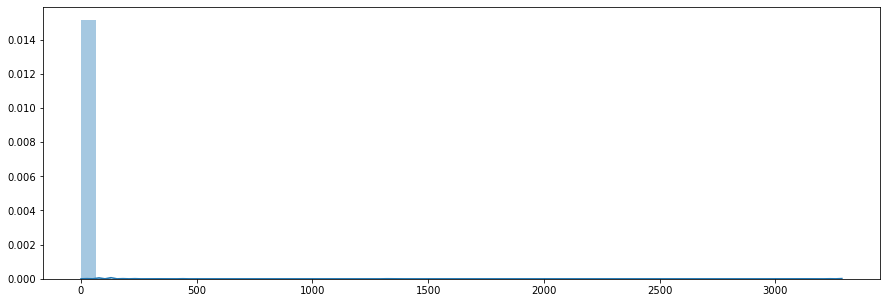

In [13]:
plt.subplots(figsize=(15,5))
sns.distplot(data_reviews.found_funny.astype(int).values)

1.6412780133252574 46.144905380071734 -136.79343812688992 140.07599415354045


Text(0, 0.5, 'Frecuencia por bins')

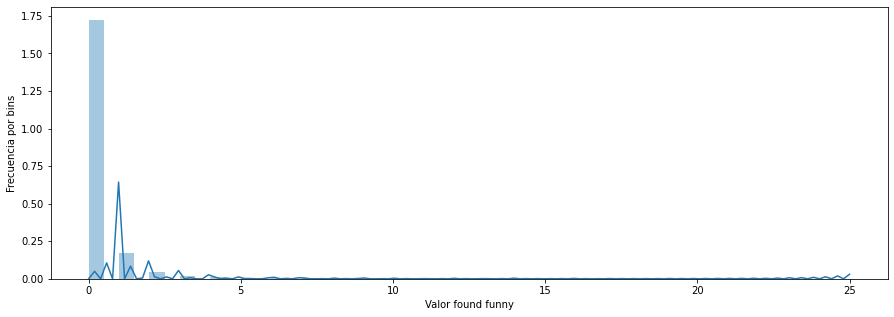

In [14]:
valor_medio = data_reviews.found_funny.mean()
std = data_reviews.found_funny.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
#mascara_outliers = np.logical_or(data_reviews.found_funny < minimo, data_reviews.found_funny > maximo)
mascara_outliers = data_reviews.found_funny < maximo
print(valor_medio, std, minimo, maximo)

data_reviews = data_reviews[mascara_outliers]
data_reviews = data_reviews[data_reviews.found_funny<=25]
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(data_reviews.found_funny)
ax.set_xlabel('Valor found funny')
ax.set_ylabel('Frecuencia por bins')

In [15]:
print(data_reviews.shape)
data_reviews.found_funny.value_counts()

(6573, 10)


0.0     5664
1.0      566
2.0      157
3.0       57
4.0       45
6.0       19
5.0       16
7.0       14
9.0        8
8.0        5
22.0       3
14.0       3
10.0       3
16.0       2
12.0       2
13.0       2
11.0       2
17.0       2
25.0       1
23.0       1
19.0       1
Name: found_funny, dtype: int64

In [16]:
data_reviews.head()

,username,hours,product_id,text,user_id,found_funny,genres,title,price,metascore
0,Emperor Palpatine,40.7,271590,"Great game, story is totally worth it but the ...",76561198048098140,0.0,"[Action, Adventure]",Grand Theft Auto V,39.99,96.0
1,feel it break,53.6,61700,"Great and unique gameplay, lovely comic style ...",76561198080371220,0.0,"[RPG, Strategy]",Might &amp; Magic: Clash of Heroes,9.99,76.0
2,Dread Guacamole,40.3,554220,"A match-3 puzzler with RPG elements, much in t...",76561198003469036,0.0,"[Casual, Indie, RPG]",Oafmatch,5.99,NaN
3,Zer0,42.0,214560,"Destructoid said it best: ""Let it stand as the...",76561197979635569,0.0,"[Action, Adventure, Indie]",Mark of the Ninja,14.99,91.0
4,MMG Man,32.2,61700,This game gets old after the first campaign. ...,76561197990406921,0.0,"[RPG, Strategy]",Might &amp; Magic: Clash of Heroes,9.99,76.0


### ¿Que significa el found funny? ¿Por que es numérico?

In [17]:
data_reviews.text.value_counts()[0:10]

                  12
.                  9
good game          8
Good game          7
great game         6
Good game.         6
fun                6
gg                 5
best game ever     5
9/10               5
Name: text, dtype: int64

In [18]:
print(len(data_reviews.text))
data_reviews = data_reviews[data_reviews.text != '']
data_reviews = data_reviews[data_reviews.text != ' ']
print(len(data_reviews.text))

6573
6561


In [19]:
data_reviews.text.str.find('batman').value_counts()

-1      6558
 227       1
 72        1
 16        1
Name: text, dtype: int64

In [20]:
data_reviews.text.str.findall('batman').value_counts()

[]          6558
[batman]       3
Name: text, dtype: int64

In [21]:
data_reviews[data_reviews.text.str.contains('batman')].head(3)

,username,hours,product_id,text,user_id,found_funny,genres,title,price,metascore
1097,Ethanback119( sick ),51.3,405310,best game ever made. um update on my review we...,76561198115874397,1.0,"[Action, Adventure]",LEGO® MARVEL's Avengers,19.99,NaN
2331,videojohnson,34.0,200260,nananananananna batmang,76561198170787014,0.0,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,19.99,91.0
5429,Zweihander37,27.3,208650,This is game of the year 2015 after The Witche...,76561198103032071,0.0,"[Action, Adventure]",Batman™: Arkham Knight,19.99,NaN


In [22]:
data_reviews.text = data_reviews.text.str.lower()

In [23]:
from collections import Counter 
import statistics 
from statistics import mode 

mas_comunes = [item for t in Counter(" ".join(data_reviews.text).split()).most_common(100) for item in t]
mas_comunes = [x for x in mas_comunes if not isinstance(x, int)]
mas_comunes

['the',
 'and',
 'to',
 'a',
 'of',
 'you',
 'i',
 'is',
 'game',
 'it',
 'this',
 'in',
 'that',
 'for',
 'but',
 'with',
 'are',
 'have',
 'on',
 'as',
 'not',
 'if',
 'can',
 'your',
 'be',
 'like',
 'so',
 'or',
 'just',
 'my',
 'was',
 'all',
 'more',
 'get',
 "it's",
 'will',
 'at',
 'one',
 'good',
 'game.',
 'there',
 'very',
 'an',
 'they',
 'some',
 'from',
 'really',
 'has',
 '-',
 'play',
 'its',
 'great',
 'even',
 'out',
 'do',
 'no',
 'fun',
 'when',
 'only',
 'game,',
 'up',
 'would',
 'what',
 'much',
 'by',
 'me',
 'which',
 'time',
 'about',
 'games',
 'still',
 'then',
 'than',
 'love',
 "don't",
 'other',
 'make',
 'into',
 'because',
 'also',
 'it.',
 'best',
 'first',
 'new',
 'them',
 'most',
 'how',
 'story',
 'many',
 'had',
 'after',
 'want',
 'any',
 'played',
 'playing',
 'every',
 'hours',
 'better',
 'well',
 'lot']

In [24]:
def letter(word_list, k):
    words = []
    for word in word_list:
        if len(word)>k:
            words.append(word)
    return words

letter(mas_comunes, 4)

['game.',
 'there',
 'really',
 'great',
 'game,',
 'would',
 'which',
 'about',
 'games',
 'still',
 "don't",
 'other',
 'because',
 'first',
 'story',
 'after',
 'played',
 'playing',
 'every',
 'hours',
 'better']

### Podemos observar las palabras más frecuentes, y cuales pueden relacionarse con la satisfacción del juego. 

### Con esta información podemos crear criterios de calificación de la review y su importancia en función del texto. 

### De cualquier manera, para entrenar un modelo que lo haga de forma inteligente, necesitaremos usar un algoritmo de Procesamiento de lenguaje natural.

### En resumen:


### 1) Usar NLP para generar una variable del tipo "metascore" pero dependiende del review individual de cada usuario, usando el texto de la recomendación. O en su defecto, verificar que una de las variables existentes tiene suficiente correlación mediante su bajo error respecto al texto de cada review.


### 3) Con ese nuevo "target" entrenar el sistema de recomendación de la Entrega 3 como nuevo Target, y comparar recomendaciones individuales. 


In [25]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk

from nltk.corpus import stopwords

# Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
# 1 solo review
index_random = np.random.randint(0,high = data_reviews.shape[0])
review = data_reviews.iloc[index_random].text
print(index_random, review)

1696 great game if you adore stratagy. it's interesting and and excellent sequel to the predicesor. but maby wait till it goes on sale.


In [27]:
review_st = nltk.tokenize.sent_tokenize(review)
review_st

['great game if you adore stratagy.',
 "it's interesting and and excellent sequel to the predicesor.",
 'but maby wait till it goes on sale.']

In [28]:
review_wt = nltk.tokenize.word_tokenize(review)
review_wt

['great',
 'game',
 'if',
 'you',
 'adore',
 'stratagy',
 '.',
 'it',
 "'s",
 'interesting',
 'and',
 'and',
 'excellent',
 'sequel',
 'to',
 'the',
 'predicesor',
 '.',
 'but',
 'maby',
 'wait',
 'till',
 'it',
 'goes',
 'on',
 'sale',
 '.']

In [29]:
stop_words = set(stopwords.words("english"))
for w in review_st:
    if w not in stop_words:
        pass # Do something.

for palabra in stop_words:
    break

In [30]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [31]:
review_wt_sin_sw = [word for word in review_wt if word not in stopwords]
review_wt_sin_sw

['great',
 'game',
 'adore',
 'stratagy',
 '.',
 "'s",
 'interesting',
 'excellent',
 'sequel',
 'predicesor',
 '.',
 'maby',
 'wait',
 'till',
 'goes',
 'sale',
 '.']

In [32]:
freq = nltk.FreqDist(review_wt_sin_sw)
freq

FreqDist({'.': 3, 'great': 1, 'game': 1, 'adore': 1, 'stratagy': 1, "'s": 1, 'interesting': 1, 'excellent': 1, 'sequel': 1, 'predicesor': 1, ...})

In [33]:
filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")

# data_reviews Completo

data_reviews_text = []
for i in range(data_reviews.shape[0]):
    review = data_reviews.iloc[i].text
    review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review)
    review = [word for word in review if word not in stopwords]
    review = [word for word in review if word not in filtrar]

    data_reviews_text.append(review)

In [34]:
data_reviews.found_funny.describe()

count    6561.000000
mean        0.301174
std         1.257955
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        25.000000
Name: found_funny, dtype: float64

In [35]:
data_reviews.head(3)

,username,hours,product_id,text,user_id,found_funny,genres,title,price,metascore
0,Emperor Palpatine,40.7,271590,"great game, story is totally worth it but the ...",76561198048098140,0.0,"[Action, Adventure]",Grand Theft Auto V,39.99,96.0
1,feel it break,53.6,61700,"great and unique gameplay, lovely comic style ...",76561198080371220,0.0,"[RPG, Strategy]",Might &amp; Magic: Clash of Heroes,9.99,76.0
2,Dread Guacamole,40.3,554220,"a match-3 puzzler with rpg elements, much in t...",76561198003469036,0.0,"[Casual, Indie, RPG]",Oafmatch,5.99,NaN


In [36]:
data_reviews_text[:3]

[['great',
  'game',
  'story',
  'totally',
  'worth',
  'online',
  'takes',
  'constant',
  'disconnections',
  'friends',
  'leaving',
  'heists',
  'crashing',
  'forth',
  'bad',
  'take',
  'another',
  '10',
  'min',
  'get',
  'everyone',
  'back',
  'game',
  'dc',
  'everyone',
  'took',
  'friends',
  'f',
  'cking',
  '3',
  'c',
  'unting',
  'days',
  'one',
  'heist',
  'one',
  'every',
  'f',
  'cking',
  'time',
  'played',
  'someone',
  'would',
  'dc',
  'would',
  'start',
  'stupid',
  'mother',
  'f',
  'cking',
  'hesit',
  'generally',
  'worse',
  'servers',
  'ubisoft',
  'taking',
  'f',
  'cking',
  'p',
  'ss',
  'especially',
  'game',
  'years',
  'ubisoft',
  'get',
  'f',
  'cking',
  'together',
  'fix',
  'one',
  'excuses',
  'servers',
  'f',
  'ck',
  'rockstar',
  'ing',
  'good',
  'day'],
 ['great',
  'unique',
  'gameplay',
  'lovely',
  'comic',
  'style',
  'visuals',
  'one',
  'greatest',
  'soundtracks',
  'ever',
  'tracks',
  'heroes'

In [37]:
list(itertools.chain('ABC', 'DEF'))

['A', 'B', 'C', 'D', 'E', 'F']

In [38]:
data_reviews_text = list(itertools.chain(*data_reviews_text))
data_reviews_text[0:10]

['great',
 'game',
 'story',
 'totally',
 'worth',
 'online',
 'takes',
 'constant',
 'disconnections',
 'friends']

In [39]:
freq_data_reviews_text = nltk.FreqDist(data_reviews_text)
freq_data_reviews_text

FreqDist({'game': 12512, 'not': 3206, 'like': 2867, 'good': 2243, 'get': 2199, 'one': 2098, 'play': 1859, 'fun': 1766, 'great': 1720, 'really': 1648, ...})

In [40]:
df_freq_reviews_text = pd.DataFrame(list(freq_data_reviews_text.items()), columns = ["Word","Frequency"])
df_freq_reviews_text.head()

,Word,Frequency
0,great,1720
1,game,12512
2,story,1114
3,totally,101
4,worth,584


In [41]:
df_freq_reviews_text.sort_values('Frequency',ascending=False, inplace = True)
df_freq_reviews_text.head()

,Word,Frequency
1,game,12512
166,not,3206
119,like,2867
56,good,2243
19,get,2199


In [42]:
df_freq_reviews_text.reset_index(drop = True, inplace=True)
df_freq_reviews_text.head()

,Word,Frequency
0,game,12512
1,not,3206
2,like,2867
3,good,2243
4,get,2199


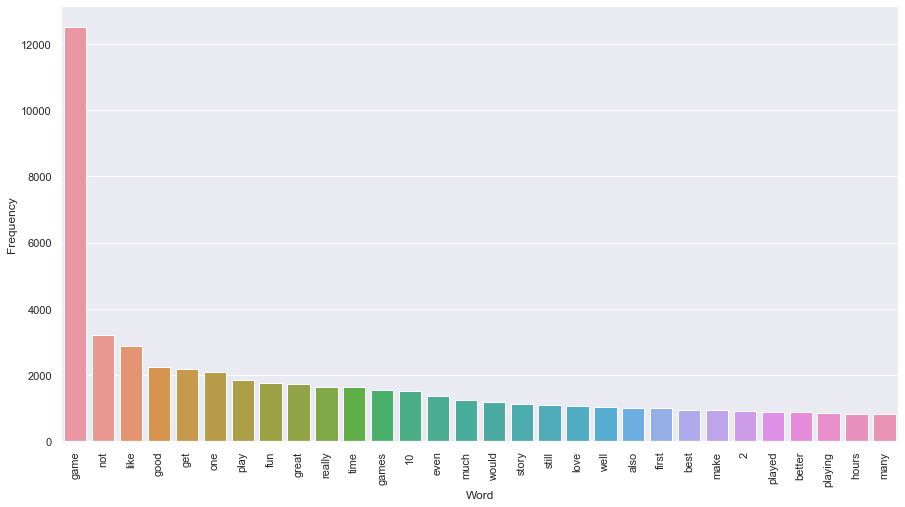

In [43]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_freq_reviews_text.iloc[:30].Word, y = df_freq_reviews_text.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

#### Stematización

In [44]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('english')
#stopword.remove('no')
#stopword.remove('not')

In [45]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
review_list=[]
for review in data_reviews.text:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review=re.sub("[^a-zA-Z]"," ",str(review))
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras del review
    review=nltk.word_tokenize(review)
    # Eliminamos las palabras de menos de 3 letras
    review = [palabra for palabra in review if len(palabra)>3]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    review=[stemmer.stem(palabra) for palabra in review]
    # Por ultimo volvemos a unir el review
    review=" ".join(review)
    
    # Vamos armando una lista con todos los reviewes
    review_list.append(review)
    #data_reviews["review_normalizado"] = review_list


In [46]:
data_reviews["review_stem"] = review_list
data_reviews.tail()

,username,hours,product_id,text,user_id,found_funny,genres,title,price,metascore,review_stem
6599,TheGeekyGangsta,31.9,252490,great game. has some jerks that kill you with ...,76561198118694672,0.0,"[Action, Adventure, Indie, Massively Multiplay...",Rust,19.99,NaN,great game jerk kill reason make hous sleep fast
6600,Mill City Rep,48.9,252490,"alpha version release. so far, a lot of fun. t...",76561197993644476,0.0,"[Action, Adventure, Indie, Massively Multiplay...",Rust,19.99,NaN,alpha version releas think minecraft dayz open...
6601,Emtec95®,127.8,252490,"true survival, not only the invironment but al...",76561198005998751,0.0,"[Action, Adventure, Indie, Massively Multiplay...",Rust,19.99,NaN,true surviv inviron also peopl
6602,Boom! MIss! Leonid.,114.5,252490,it is really fun and if you are a girl you get...,76561198065201420,0.0,"[Action, Adventure, Indie, Massively Multiplay...",Rust,19.99,NaN,realli girl littl wiener like
6603,Andrew,85.9,252490,nude caveman survival... with guns... and wo...,76561198047120964,0.0,"[Action, Adventure, Indie, Massively Multiplay...",Rust,19.99,NaN,nude caveman surviv gun wooden castl dont spee...


In [47]:
filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")

# data_reviews Completo

data_reviews_review_stem = []
for i in range(data_reviews.shape[0]):
    review = data_reviews.iloc[i].review_stem
    review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review)
    review = [word for word in review if word not in stopwords]
    review = [word for word in review if word not in filtrar]

    data_reviews_review_stem.append(review)

In [48]:
type(data_reviews_review_stem)

list

In [49]:
len(data_reviews_review_stem)

6561

In [50]:
data_reviews_review_stem[:5]

[['great',
  'game',
  'stori',
  'total',
  'worth',
  'onlin',
  'take',
  'constant',
  'disconnect',
  'friend',
  'leav',
  'heist',
  'crash',
  'forth',
  'take',
  'anoth',
  'everyon',
  'back',
  'game',
  'everyon',
  'took',
  'friend',
  'cking',
  'unt',
  'day',
  'heist',
  'everi',
  'cking',
  'time',
  'play',
  'someon',
  'would',
  'would',
  'start',
  'stupid',
  'mother',
  'cking',
  'hesit',
  'gener',
  'wors',
  'server',
  'ubisoft',
  'take',
  'cking',
  'especi',
  'game',
  'year',
  'ubisoft',
  'cking',
  'togeth',
  'excus',
  'server',
  'rockstar',
  'good'],
 ['great',
  'uniqu',
  'gameplay',
  'love',
  'comic',
  'style',
  'visual',
  'greatest',
  'soundtrack',
  'ever',
  'track',
  'hero',
  'might',
  'magic',
  'found',
  'well',
  'slightli',
  'alter',
  'rework',
  'nice',
  'might',
  'magic',
  'lore',
  'atmospher',
  'enough',
  'make',
  'game',
  'amaz',
  'bewar',
  'multiplay',
  'suck',
  'total',
  'unbalanc',
  'artifact',


In [51]:
list(itertools.chain('ABC', 'DEF')) 

['A', 'B', 'C', 'D', 'E', 'F']

In [52]:
data_reviews_review_stem = list(itertools.chain(*data_reviews_review_stem))
data_reviews_review_stem[0:10]

['great',
 'game',
 'stori',
 'total',
 'worth',
 'onlin',
 'take',
 'constant',
 'disconnect',
 'friend']

In [53]:
freq_data_reviews_review_stem = nltk.FreqDist(data_reviews_review_stem)
freq_data_reviews_review_stem

FreqDist({'game': 14204, 'play': 3719, 'like': 3107, 'good': 2257, 'time': 2073, 'great': 1729, 'realli': 1649, 'make': 1604, 'even': 1370, 'love': 1273, ...})

In [54]:
df_freq_reviews_review_stem = pd.DataFrame(list(freq_data_reviews_review_stem.items()), columns = ["Word","Frequency"])
df_freq_reviews_review_stem.head()

,Word,Frequency
0,great,1729
1,game,14204
2,stori,1185
3,total,233
4,worth,585


In [55]:
df_freq_reviews_review_stem.sort_values('Frequency',ascending=False, inplace = True)
df_freq_reviews_review_stem.head()

,Word,Frequency
1,game,14204
23,play,3719
94,like,3107
39,good,2257
22,time,2073


In [56]:
df_freq_reviews_review_stem.reset_index(drop = True, inplace=True)
df_freq_reviews_review_stem.head()

,Word,Frequency
0,game,14204
1,play,3719
2,like,3107
3,good,2257
4,time,2073


#### Top 30 palabras CON estemizado

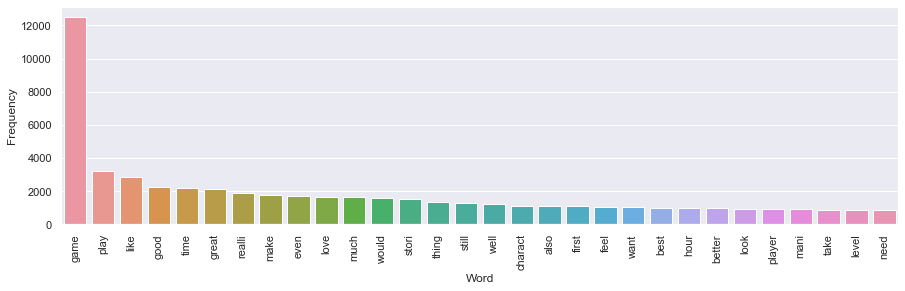

In [57]:
plt.figure(figsize = (15,4))
plot = sns.barplot(x  = df_freq_reviews_review_stem.iloc[:30].Word, y = df_freq_reviews_text.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

#### vs Top 30 palabras SIN estemizado

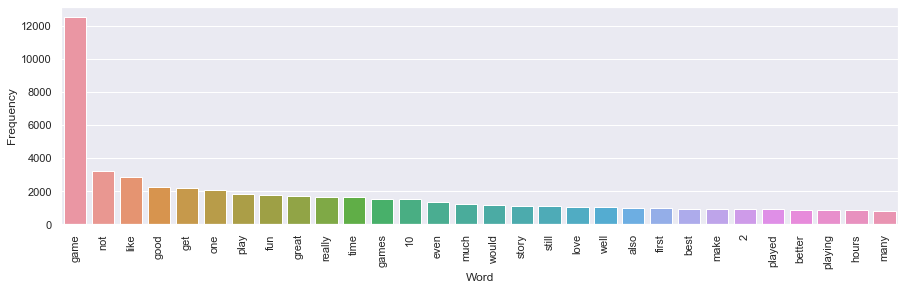

In [58]:
plt.figure(figsize = (15,4))
plot = sns.barplot(x  = df_freq_reviews_text.iloc[:30].Word, y = df_freq_reviews_text.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

#### Hay que remover palabras "obvias que no aportan valor" como Game, Games, etc.

# ¿Cual es la correlación entre las palabras del top 30 estemizadas y el found funny?

,hours,product_id,found_funny,metascore
hours,1.000000,-0.047574,0.011616,0.037226
product_id,-0.047574,1.000000,0.032688,-0.151289
found_funny,0.011616,0.032688,1.000000,-0.021765
metascore,0.037226,-0.151289,-0.021765,1.000000


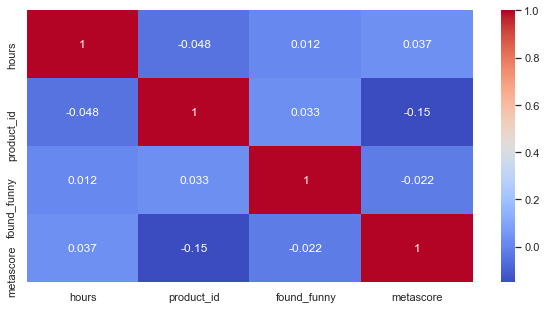

In [59]:
plt.figure(figsize=(10,5))
c= data_reviews.corr()
sns.heatmap(c,cmap='coolwarm',annot=True)
c

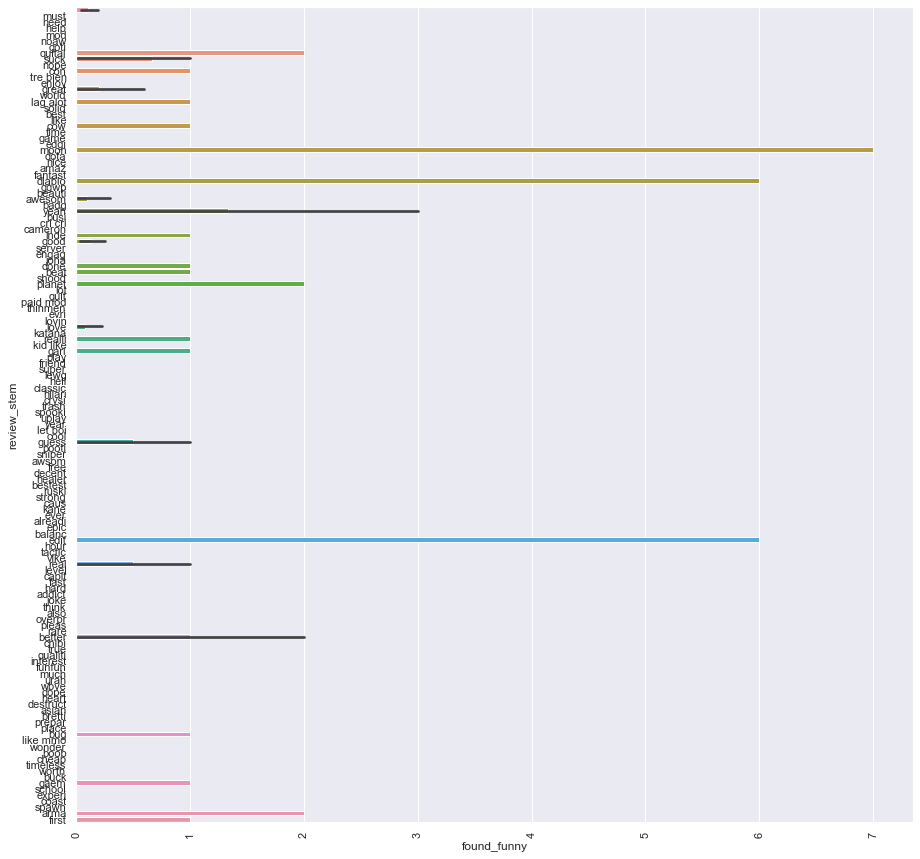

In [60]:
plt.figure(figsize = (15,15))
plot = sns.barplot(x  = data_reviews[~(data_reviews.review_stem.str.len() > 8)].found_funny, y = data_reviews[~(data_reviews.review_stem.str.len() > 8)].review_stem)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

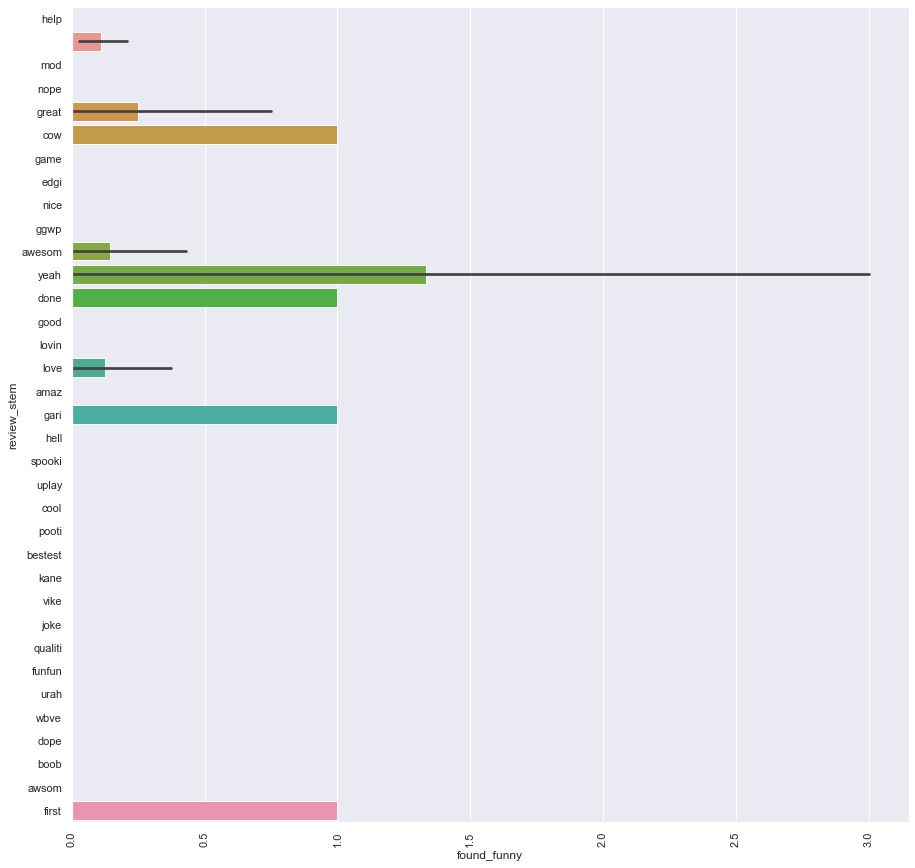

In [61]:
plt.figure(figsize = (15,15))
plot = sns.barplot(x  = data_reviews[~(data_reviews.text.str.len() > 8)].found_funny, y = data_reviews[~(data_reviews.text.str.len() > 8)].review_stem)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

## ¿porque tantos juegos tienen 1 como valor de found funny? ¿Y valor cero?

## ¿Cual es la correlación entre el found_funny y el metascore? si están altamente correlacionados quiere decir que el found funny es una medida viable de satisfacción

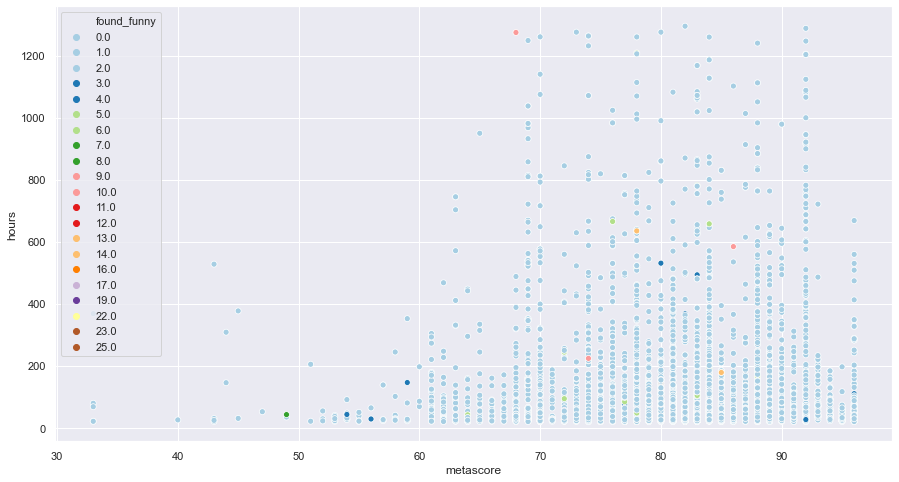

In [62]:
fig, ax = plt.subplots(figsize=(15,8))
ax= sns.scatterplot(x="metascore", y="hours", hue='found_funny', data=data_reviews, palette='Paired', legend='full')
plt.show()

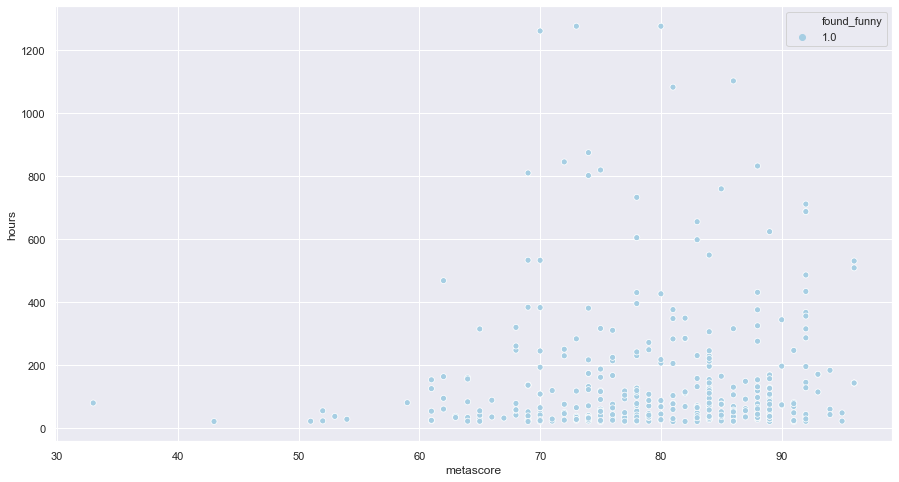

In [63]:
data_reviews_foundf_1 = data_reviews[data_reviews.found_funny==1]

fig, ax = plt.subplots(figsize=(15,8))
ax= sns.scatterplot(x="metascore", y="hours", hue='found_funny', data=data_reviews_foundf_1, palette='Paired', legend='full')
plt.show()

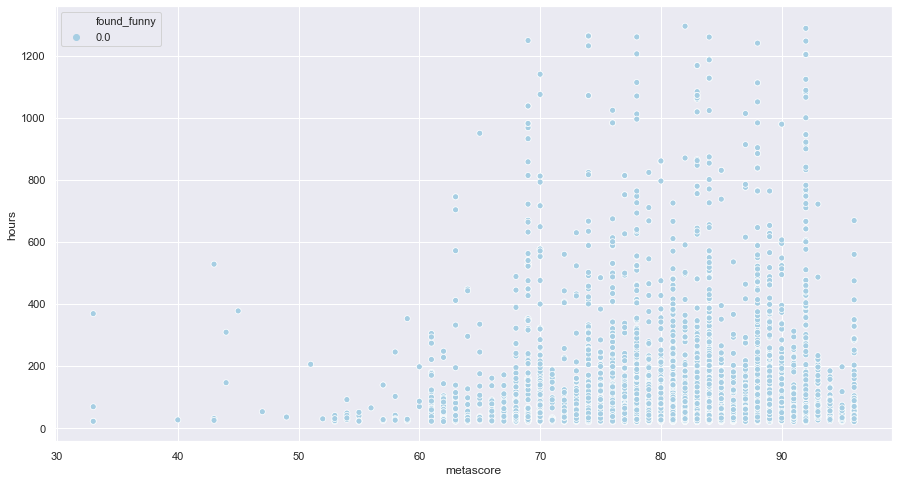

In [64]:
data_reviews_foundf_0 = data_reviews[data_reviews.found_funny==0]

fig, ax = plt.subplots(figsize=(15,8))
ax= sns.scatterplot(x="metascore", y="hours", hue='found_funny', data=data_reviews_foundf_0, palette='Paired', legend='full')
plt.show()

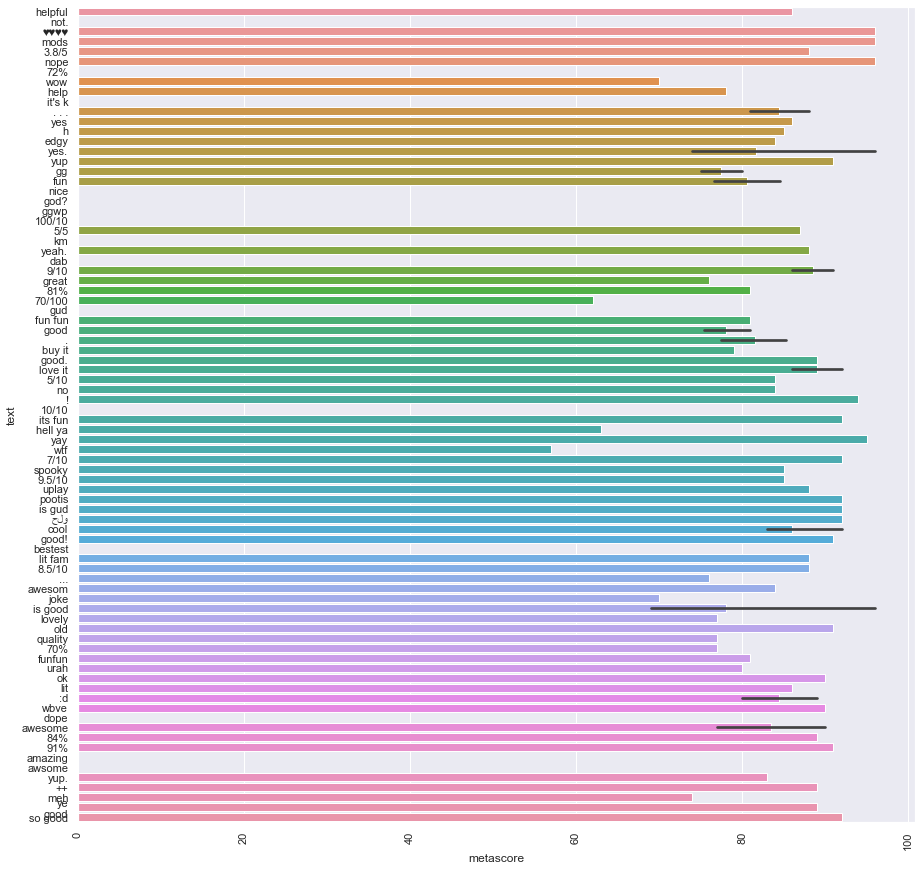

In [65]:
plt.figure(figsize = (15,15))
plot = sns.barplot(x  = data_reviews_foundf_0[~(data_reviews_foundf_0.text.str.len() > 7)].metascore, y = data_reviews_foundf_0[~(data_reviews_foundf_0.text.str.len() > 7)].text)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

## Propuesta: Usar solo los valores de found Funny 1 y 0, entrenar un algoritmo con ellos y así demostrar que el hay una relación entre el texto de review negativo y 0, y entre el texto positivo y 1

In [66]:
mascara_found_funny = np.logical_or(data_reviews['found_funny'] == 0, data_reviews['found_funny'] == 1)
data_reviews_nlp = data_reviews[mascara_found_funny]

### Lemmatizacion

In [67]:
#stop() # No remover hasta resolver problema de celda

#nltk.download()

# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

import nltk
#python -m nltk.downloader -u
nltk.download('wordnet')
#PATH_TO_NLTK_DATA=/home/username/nltk_data/
#wget https://github.com/nltk/nltk_data/archive/gh-pages.zip
#unzip gh-pages.zip
#mv nltk_data-gh-pages/ $PATH_TO_NLTK_DATA

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [68]:
# Oracion que usaremos como ejemplo
frase = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."

# Hay que regularizar el texto. Dejar solo letra, pasar a minúsculas y tokenizar:

# Sacamos todo lo que no sean letras
frase = re.sub("[^a-zA-Z]"," ",str(frase))
# Pasamos a minúsculas
frase = frase.lower()
# Tokenizamos
frase_tokens = nltk.word_tokenize(frase)

# Veamos como cambians las palabras al lemmatizar
print("{0:20}{1:20}".format("Word","Lemma"))
for palabra in frase_tokens:
    print ("{0:20}{1:20}".format(palabra,wordnet_lemmatizer.lemmatize(palabra)))

Word                Lemma               
he                  he                  
was                 wa                  
running             running             
and                 and                 
eating              eating              
at                  at                  
same                same                
time                time                
he                  he                  
has                 ha                  
bad                 bad                 
habit               habit               
of                  of                  
swimming            swimming            
after               after               
playing             playing             
long                long                
hours               hour                
in                  in                  
the                 the                 
sun                 sun                 


In [69]:
import nltk
nltk.download('averaged_perceptron_tagger')

print(nltk.pos_tag(frase_tokens))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('he', 'PRP'), ('was', 'VBD'), ('running', 'VBG'), ('and', 'CC'), ('eating', 'VBG'), ('at', 'IN'), ('same', 'JJ'), ('time', 'NN'), ('he', 'PRP'), ('has', 'VBZ'), ('bad', 'JJ'), ('habit', 'NN'), ('of', 'IN'), ('swimming', 'NN'), ('after', 'IN'), ('playing', 'VBG'), ('long', 'JJ'), ('hours', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('sun', 'NN')]


In [70]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [71]:
frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(frase)]
tipo_palabra = [get_wordnet_pos(w) for w in nltk.word_tokenize(frase)]

# Veamos como cambiaron las palabras
print("{0:20}{1:20}{2:20}".format("Palabra:","Tipo:","Lemma:"))
for i in range(len(frase_tokens)):
    print ("{0:20}{1:20}{2:20}".format(frase_tokens[i],tipo_palabra[i],frase_lemma[i]))

Palabra:            Tipo:               Lemma:              
he                  n                   he                  
was                 v                   be                  
running             v                   run                 
and                 n                   and                 
eating              v                   eat                 
at                  n                   at                  
same                a                   same                
time                n                   time                
he                  n                   he                  
has                 v                   have                
bad                 a                   bad                 
habit               n                   habit               
of                  n                   of                  
swimming            v                   swim                
after               n                   after               
playing             v   

In [72]:
# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Importamos esta libreria que nos permite reemplzar caracteres
import re

#data_reviews = pd.read_json('Sarcasm_texts_data_reviews.json', lines= True)
#data_reviews = pd.concat([data_reviews.text,data_reviews.found_funny],axis=1)
data_reviews_nlp=data_reviews_nlp[['text','found_funny']]
data_reviews_nlp.dropna(axis=0,inplace=True)

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('english')
#stopword.remove('no')
#stopword.remove('not')

In [73]:
review_list=[]
for review in data_reviews_nlp.text:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review=re.sub("[^a-zA-Z]"," ",str(review))
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras
    review=nltk.word_tokenize(review)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in review]
    
    
    # Eliminamos las palabras d emenos de 3 letras
    review = [palabra for palabra in review if len(palabra)>3]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el review
    review=" ".join(review)
    #data_reviews["review_normalizado"] = review_list
    review_list.append(review)
    
data_reviews_nlp["review_lemm"] = review_list
data_reviews_nlp.tail()

,text,found_funny,review_lemm
6599,great game. has some jerks that kill you with ...,0.0,great game jerks kill reason make house sleepi...
6600,"alpha version release. so far, a lot of fun. t...",0.0,alpha version release think minecraft dayz ope...
6601,"true survival, not only the invironment but al...",0.0,true survival invironment also people
6602,it is really fun and if you are a girl you get...,0.0,really girl little wieners like
6603,nude caveman survival... with guns... and wo...,0.0,nude caveman survival guns wooden castles dont...


In [74]:
data_reviews_lemm = pd.concat([data_reviews_nlp.review_lemm,data_reviews_nlp.found_funny],axis=1)
#data_reviews_lemm.dropna(axis=0,inplace=True)  # Por si quedaron reviewes vacios
data_reviews_lemm.head()

,review_lemm,found_funny
0,great game story totally worth online takes co...,0.0
1,great unique gameplay lovely comic style visua...,0.0
2,match puzzler elements much vein puzzle quest ...,0.0
3,destructoid said best stand benchmark stealth ...,0.0
4,game gets first campaign addition story rather...,0.0


0.0    5654
1.0     564
Name: found_funny, dtype: int64

#### Vectorizar

In [76]:
# Tomamso la lista de palabras y el vector que nos dice que valor de found funny tiene el review
list_reviews = list(data_reviews_lemm['review_lemm'].values)
found_fun = data_reviews_lemm['found_funny'].values

## Para probar con Stemmizer:
#list_reviews = list(data_reviews_stem'review_stem'].values)
#found_fun = data_reviews_stem['found_funny'].values

from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

matriz_reviews = cou_vec.fit_transform(list_reviews)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 primeras palabras mas usadas: ",all_words[0:50])

50 primeras palabras mas usadas:  ['abilities', 'ability', 'able', 'absolutely', 'access', 'account', 'achievements', 'across', 'acting', 'action', 'actions', 'active', 'actual', 'actually', 'added', 'addicting', 'addictive', 'adding', 'addition', 'adds', 'adventure', 'alien', 'aliens', 'allow', 'allows', 'almost', 'alone', 'along', 'alot', 'alpha', 'already', 'also', 'although', 'always', 'amazing', 'ammo', 'amount', 'animations', 'annoying', 'another', 'anymore', 'anyone', 'anything', 'anyway', 'apart', 'area', 'areas', 'armor', 'army', 'around']


## Modelado del algoritmo de NLP

In [77]:
x = matriz_reviews.toarray()
y = found_fun

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["not funny","funny"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

#### Modelo Naive Bayes

In [78]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))

acc :  0.3311897106109325


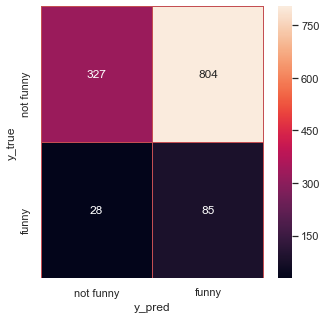

In [79]:
y_pred=nb.predict(xtest)
confusion(ytest,y_pred)

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))

acc:  0.9091639871382636


#### ¿Por que tal alto el accuraccy?

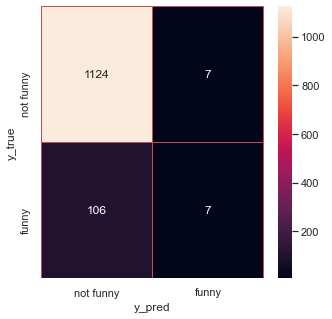

In [81]:
y_pred=rf.predict(xtest)
confusion(ytest,y_pred)

In [82]:
data_reviews_nlp.found_funny.value_counts()

0.0    5654
1.0     564
Name: found_funny, dtype: int64

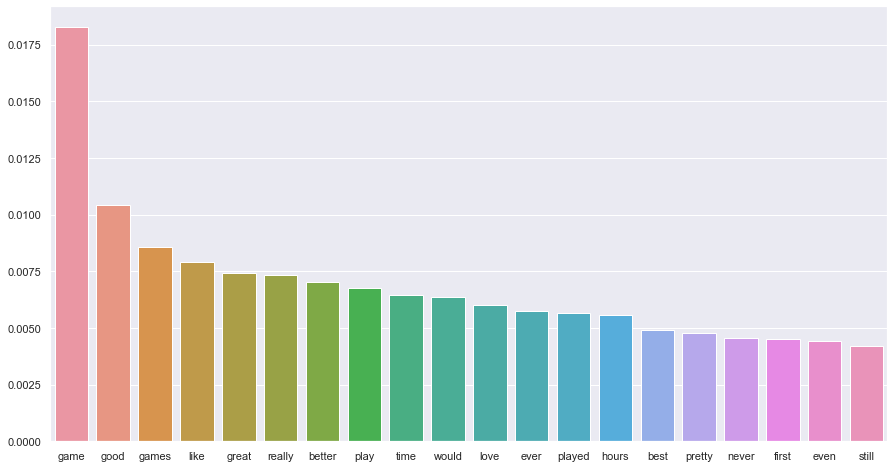

In [83]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

## Probemos ahora con found funny entre 0 y 25.

In [84]:
data_reviews_nlp = data_reviews.copy()

data_reviews_nlp=data_reviews_nlp[['text','found_funny']]
data_reviews_nlp.dropna(axis=0,inplace=True)

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('english')

review_list=[]
for review in data_reviews_nlp.text:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review=re.sub("[^a-zA-Z]"," ",str(review))
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras
    review=nltk.word_tokenize(review)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in review]
    
    
    # Eliminamos las palabras d emenos de 3 letras
    review = [palabra for palabra in review if len(palabra)>3]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el review
    review=" ".join(review)
    #data_reviews["review_normalizado"] = review_list
    review_list.append(review)
    
data_reviews_nlp["review_lemm"] = review_list

data_reviews_lemm = pd.concat([data_reviews_nlp.review_lemm, data_reviews_nlp.found_funny], axis=1)

# Tomamso la lista de palabras y el vector que nos dice que valor de found funny tiene el review
list_reviews = list(data_reviews_lemm['review_lemm'].values)
found_fun = data_reviews_lemm['found_funny'].values

## Para probar con Stemmizer:
#list_reviews = list(data_reviews_stem'review_stem'].values)
#found_fun = data_reviews_stem['found_funny'].values

from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

matriz_reviews = cou_vec.fit_transform(list_reviews)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
#print("50 primeras palabras mas usadas: ",all_words[0:50])

x = matriz_reviews.toarray()
y = found_fun

print(len(x))
print(len(y))
#xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

6561
6561


In [85]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42)

In [86]:
rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))

acc:  0.8796648895658796


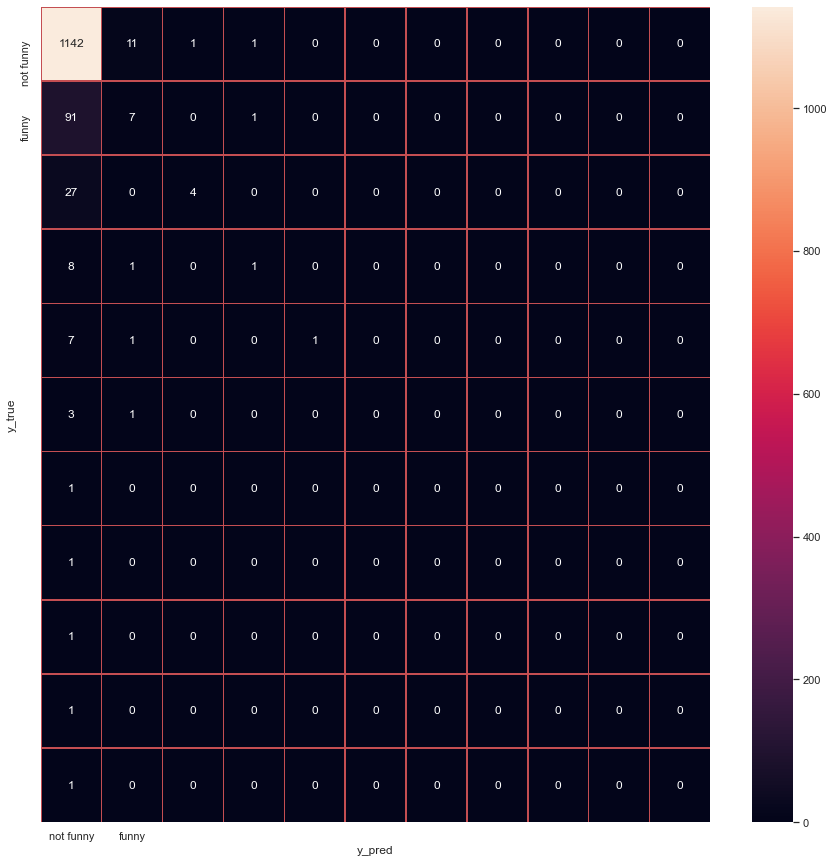

In [87]:
def confusion(ytest,y_pred):
    names=["not funny","funny"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(15,15))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

y_pred=rf.predict(xtest)
confusion(ytest,y_pred)

In [88]:
data_reviews_nlp.found_funny.value_counts()

0.0     5654
1.0      564
2.0      157
3.0       57
4.0       45
6.0       19
5.0       16
7.0       14
9.0        8
8.0        5
22.0       3
14.0       3
10.0       3
16.0       2
12.0       2
13.0       2
11.0       2
17.0       2
25.0       1
23.0       1
19.0       1
Name: found_funny, dtype: int64

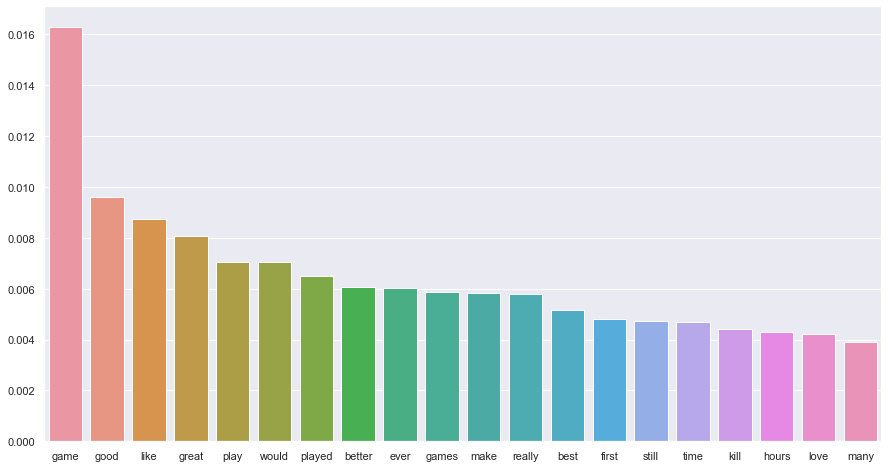

In [89]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

## Queda demostrado que found funny es una medida de calificación del juego individual, que depende de cada review usuario y por lo tanto puede usarse para entrenar recomendaciones.

In [90]:
!pip install surprise

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

reader = Reader(rating_scale=(1, 100))

df1 = data_reviews.copy()
df1 = df1.drop(['username','hours','text','metascore','genres','title','title','price','review_stem'], axis=1)
df1.head(3)

,product_id,user_id,found_funny
0,271590,76561198048098140,0.0
1,61700,76561198080371220,0.0


In [91]:
from surprise import SVD

reader = Reader(rating_scale=(0, 25))
data = Dataset.load_from_df(df1[['user_id', 'product_id', 'found_funny']], reader)
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD(n_factors=5, n_epochs=20, lr_all=0.005, reg_all=0.002)
algo.fit(trainset)
predictions = algo.test(testset)

In [92]:
usuario = 76561198011965365
df_user = df1[(df1['user_id'] == usuario) & (df1['found_funny'] > 0)]
df_user = df_user.reset_index(drop=True)

recomendaciones_usuario = data_games[['title','product_id']].iloc[:4499].copy()
recomendaciones_usuario.index = recomendaciones_usuario.product_id
recomendaciones_usuario = recomendaciones_usuario.drop(['product_id'], axis=1)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,NaN


In [93]:
usuario_vistas = df1[['user_id', 'product_id', 'found_funny']][df1['user_id'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(0, 3)


,user_id,product_id,found_funny


In [94]:
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,product_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,NaN


In [95]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,product_id,title,Estimate_Score
271,6060,"Star Wars: Battlefront 2 (Classic, 2005)",2.144425
2954,334230,Town of Salem,2.062658
650,39160,Dungeon Siege III,1.812679
2253,242760,The Forest,1.274510
126,13520,Far Cry®,1.191381
3356,350810,Pixel Puzzles 2: Anime,1.048233
968,212500,The Lord of the Rings Online™,1.021843
2785,246090,Spacebase DF-9,0.906971
3167,266510,Hand of Fate,0.852305
1814,246840,FATE,0.806784


In [96]:
rmse_svd_3 = accuracy.rmse(predictions)

accuracy.rmse(predictions)

RMSE: 1.4925
RMSE: 1.4925


1.4924647545734913

## Misión cumplida!

## Hay una mejora considerable de este modelo en comparación a cuando se usa metascore como target!


## Ahora vamos a scrappear alguna review nueva y recomendarle juegos según este modelo de buen performance, siempre que el nuevo juego esté contenido en dataset actual

In [383]:
game_to_scrap_from_reviews = 440# Acá agregar el product id del juego que deseemos buscar su última review de steam
game_to_scrap_from_reviews = str(game_to_scrap_from_reviews)

In [384]:
from bs4 import BeautifulSoup
import requests

url="https://steamcommunity.com/app/"+game_to_scrap_from_reviews+"/negativereviews/?browsefilter=toprated&snr=1_5_100010_&filterLanguage=english"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

#text = soup.find('div',class_="apphub_CardContentAuthorName online ellipsis")
#pr||int(text.get_text())
#print(type(text.get_text()))

links = []
for link in soup.find_all('a'):
    links.append(link.get('href'))
#print(links)
#print(len(links))

matching = [s for s in links if "profiles" in s]
matching[0]

'https://steamcommunity.com/profiles/76561198062578952/'

In [385]:
matching[0].strip('https://steamcommunity.com/profiles/')

'76561198062578952'

In [386]:
url=matching[0]+"/recommended/"+game_to_scrap_from_reviews+"/" 

#url="https://steamcommunity.com/profiles/76561198062578952/recommended/440/" 

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

text = soup.find('div',id="ReviewText")
print(text.get_text())


								Abandoned by Valve.It shatters my heart in a thousand pieces to see this everlasting community being destroyed by hackers, and Valve not giving two craps about this game.Seriously VAC is a joke.They have got rigged of the lagbots, i'll give them that. But i'm not going to remove this review untill Valve actually does something about those hackers and release the "Heavy Update".							


## El formato de la página web scrapeable de Steam es "Nombre de usuario" + "id producto review"

usuario freakfantom
id producto 725280

https://steamcommunity.com/id/freakfantom/recommended/725280/

usuario WestX_X
id producto 945360 (Among Us)

https://steamcommunity.com/id/WestX_X/recommended/945360/

## Siguiendo ese formato, es posible randomizar la búsqueda de nuevas reviews para agregarlas a nuevos dataset.

## En función del texto, vamos a predecir el found funny del mismo, y con ambos valores, predecir juegos que le gusten

In [387]:
text=re.sub("[^a-zA-Z]"," ",str(text))
text=text.lower()
text=nltk.word_tokenize(text)
frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]    
text = [palabra for palabra in text if len(palabra)>3]
text = [palabra for palabra in text if not palabra in stopwords]
text=" ".join(text)
text = text.strip('reviewtext ')

text

'abandoned valve shatters heart thousand pieces everlasting community destroyed hackers valve giving craps game seriously joke rigged lagbots give going remove review untill valve actually something hackers release heavy upda'

In [388]:
text = np.array([text])

text

array(['abandoned valve shatters heart thousand pieces everlasting community destroyed hackers valve giving craps game seriously joke rigged lagbots give going remove review untill valve actually something hackers release heavy upda'],
      dtype='<U224')

In [389]:
list_reviews = list(data_reviews_lemm['review_lemm'].values)
print(list_reviews[1])
list_reviews.append(text.tolist()[0])
print(' ')
print(list_reviews[-1])

great unique gameplay lovely comic style visuals greatest soundtracks ever tracks heroes might magic found well slightly altered reworked nice might magic lore atmosphere enough make game amazing beware multiplayer sucks totally unbalanced artifacts also achievements grindy recommend using controller
 
abandoned valve shatters heart thousand pieces everlasting community destroyed hackers valve giving craps game seriously joke rigged lagbots give going remove review untill valve actually something hackers release heavy upda


In [390]:
found_fun = data_reviews_lemm['found_funny'].values

max_features=1000

cou_vec=CountVectorizer(max_features=max_features) 

matriz_reviews = cou_vec.fit_transform(list_reviews)

all_words = cou_vec.get_feature_names()

#xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42)

xtrain = matriz_reviews[0:-1].toarray()
ytrain = found_fun
xtest = matriz_reviews[-1]

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)


y_pred=rf.predict(xtest)
print(y_pred[0])

0.0


### Hemos obtenido la predicción de found funny o target según la review scrapeada. 

### Intentemos recomendarle juegos a este usuario, utilizando el found funny para el juego en cuestion.

In [392]:
usuario = int(matching[0].strip('https://steamcommunity.com/profiles/'))
df_user = df1[(df1['user_id'] == usuario) & (df1['found_funny'] == y_pred[0])]
df_user = df_user.reset_index(drop=True)

recomendaciones_usuario = data_games[['title','product_id']].iloc[:4499].copy()
recomendaciones_usuario.index = recomendaciones_usuario.product_id
recomendaciones_usuario = recomendaciones_usuario.drop(['product_id'], axis=1)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,NaN
